In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy
def visualize_matches(I1, I2, matches):
    # display two images side-by-side with matches
    # this code is to help you visualize the matches, you don't need
    # to use it to produce the results for the assignment

    I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
    I3[:,:I1.size[0],:] = I1
    I3[:,I1.size[0]:,:] = I2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I3).astype(np.uint8))
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot( matches[:,2] + I1.size[0], matches[:,3], '+r')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
    plt.show()

In [2]:
def visualize_fundamental(matches, F, I1, I2):
    # Visualize the fundamental matrix in image 2
    N = len(matches)
    M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose() # transform points from 
    # the first image to get epipolar lines in the second image

    # find points on epipolar lines L closest to matches(:,3:4)
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1, np.kron(np.ones((3,1)), l).transpose())   # rescale the line
    pt_line_dist = np.multiply(L, np.c_[matches[:, 2:4], np.ones((N, 1))]).sum(axis = 1)
    closest_pt = matches[:, 2:4] - np.multiply(L[:, 0:2],np.kron(np.ones((2, 1)), pt_line_dist).transpose())

    # find endpoints of segment on epipolar line (for display purposes)
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]] * 10    # offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]] * 10

    # display points and segments of corresponding epipolar lines
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I2).astype(np.uint8))
    ax.plot(matches[:, 2],matches[:, 3],  '+r')
    ax.plot([matches[:, 2], closest_pt[:, 0]],[matches[:, 3], closest_pt[:, 1]], 'r')
    ax.plot([pt1[:, 0], pt2[:, 0]],[pt1[:, 1], pt2[:, 1]], 'g')
    plt.show()

def evaluate_fundamental(matches, F):
    N = len(matches)
    points1, points2 = matches[:, :2], matches[:, 2:]
    points1_homogeneous = np.concatenate([points1, np.ones((N, 1))], axis=1)
    points2_homogeneous = np.concatenate([points2, np.ones((N, 1))], axis=1)
    product = np.dot(np.dot(points1_homogeneous, F), points2_homogeneous.T)
    diag = np.diag(product)
    residual = np.mean(diag ** 2)
    return residual

In [3]:
library_image1 = Image.open('data/library1.jpg')
library_image2 = Image.open('data/library2.jpg')
library_matches = np.loadtxt('data/library_matches.txt')

lab_image1 = Image.open('data/lab1.jpg')
lab_image2 = Image.open('data/lab2.jpg')
lab_matches = np.loadtxt('data/lab_matches.txt')

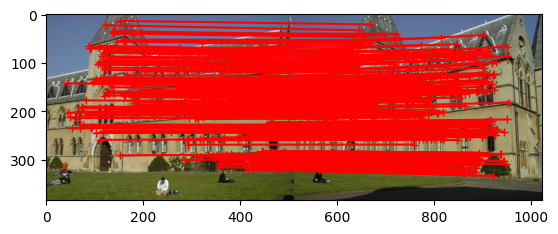

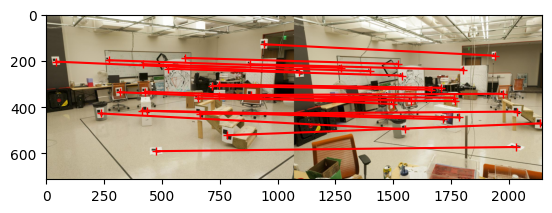

In [4]:
visualize_matches(library_image1, library_image2, library_matches)
visualize_matches(lab_image1, lab_image2, lab_matches)

In [15]:
def normalize_points(pts):
    # Normalize points
    # 1. calculate mean and std
    # 2. build a transformation matrix
    # :return normalized_pts: normalized points
    # :return T: transformation matrix from original to normalized points
    mean = np.mean(pts, axis = 0)
    centered_pts = pts - mean
    mean_squared_distance = np.mean(np.sum(centered_pts**2, axis=1))
    scale_factor = np.sqrt(2 / mean_squared_distance)
    normalized_pts = centered_pts * scale_factor
    T = np.array([[scale_factor, 0, -mean[0] * scale_factor],
                  [0, scale_factor, -mean[1] * scale_factor],
                  [0, 0, 1]])
    return normalized_pts, T

In [18]:
NORMALIZE = True
def fit_fundamental(matches):
    # Calculate fundamental matrix from ground truth matches
    # 1. (normalize points if necessary)
    # 2. (x1, y1, 1) * F * (x2, y2, 1)^T = 0 -> AX = 0
    # X = (f_11, f_12, ..., f_33) 
    # build A(N x 9) from matches(N x 4) according to Eight-Point Algorithm
    # 3. use SVD (np.linalg.svd) to decomposite the matrix
    # 4. take the smallest eigen vector(9, ) as F(3 x 3)
    # 5. use SVD to decomposite F, set the smallest eigenvalue as 0, and recalculate F
    # 6. Report your fundamental matrix results
    if NORMALIZE:
        pts1, T1 = normalize_points(matches[:, :2])
        pts2, T2 = normalize_points(matches[:, 2:])
        A = []
        for i in range(pts1.shape[0]):
            x0,y0 = pts1[i]
            x1,y1 = pts2[i]
            A.append([x1 * x0, x1 * y0, x1, y1 * x0, y1 * y0, y1, x0, y0, 1])
        A = np.array(A)
        _, _, V = np.linalg.svd(A)
        F = V[-1, :].reshape((3, 3))
        U, S, V = np.linalg.svd(F)
        S[-1] = 0
        F = T2.T @ U @ np.diag(S) @ V @ T1
        return F
    else:
        A = []
        for match in matches:
            x0,y0,x1,y1=match
            A.append([x1 * x0, x1 * y0, x1, y1 * x0, y1 * y0, y1, x0, y0, 1])
        A = np.array(A)
        _, _, V = np.linalg.svd(A)
        F = V[-1, :].reshape((3, 3))
        U, S, V = np.linalg.svd(F)
        S[-1] = 0
        F = U @ np.diag(S) @ V
        return F

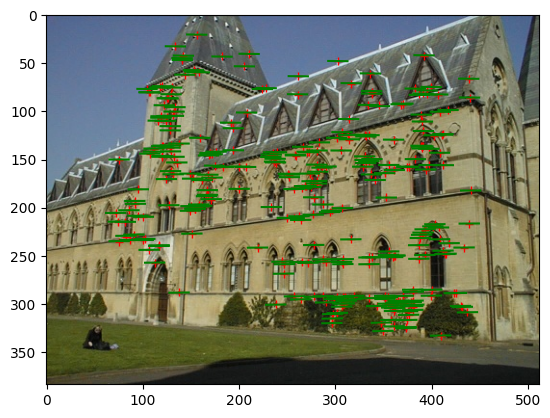

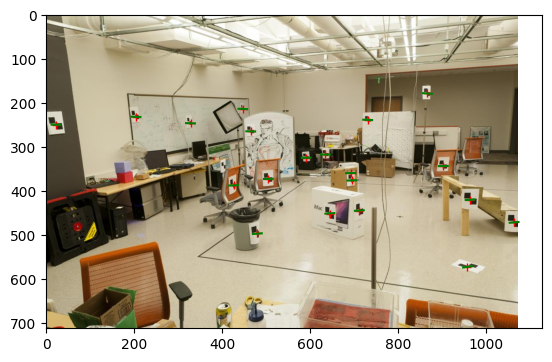

In [19]:
library_F = fit_fundamental(library_matches) # this is a function that you should write
visualize_fundamental(library_matches, library_F, library_image1, library_image2)
assert evaluate_fundamental(library_matches, library_F) < 0.5
lab_F = fit_fundamental(lab_matches) # this is a function that you should write
visualize_fundamental(lab_matches, lab_F, lab_image1, lab_image2) 
assert evaluate_fundamental(lab_matches, lab_F) < 0.5

In [22]:
def evaluate_points(P, points_2d, points_3d):
    # Visualize the actual 2D points and the projected 2D points calculated from
    # the projection matrix
    # You do not need to modify anything in this function, although you can if you
    # want to
    # :param P: projection matrix 3 x 4
    # :param points_2d: 2D points N x 2
    # :param points_3d: 3D points N x 3
    # :return points_3d_proj: project 3D points to 2D by P
    # :return residual: residual of points_3d_proj and points_2d

    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(P, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [28]:
def calc_projection(points_2d, points_3d):
    # Calculate camera projection matrices
    # 1. Points_2d = P * Points_3d -> AX = 0
    # X = (p_11, p_12, ..., p_34) is flatten of P
    # build matrix A(2*N, 12) from points_2d
    # 2. SVD decomposite A
    # 3. take the eigen vector(12, ) of smallest eigen value
    # 4. return projection matrix(3, 4)
    # :param points_2d: 2D points N x 2
    # :param points_3d: 3D points N x 3
    # :return P: projection matrix
    A = []
    for i in range(points_2d.shape[0]):
        X, Y, Z = points_3d[i]
        u, v = points_2d[i]
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u * X, -u * Y, -u * Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v * X, -v * Y, -v * Z, -v])
    _, _, V = np.linalg.svd(A)
    P = V[-1, :].reshape((3, 4))
    return P

lab_points_3d = np.loadtxt('data/lab_3d.txt')

projection_matrix = dict()
for key, points_2d in zip(["lab_a", "lab_b"], [lab_matches[:, :2], lab_matches[:, 2:]]):
    P = calc_projection(points_2d, lab_points_3d)
    points_3d_proj, residual = evaluate_points(P, points_2d, lab_points_3d)
    distance = np.mean(np.linalg.norm(points_2d - points_3d_proj))
    # Check: residual should be < 20 and distance should be < 4 
    assert residual < 20.0 and distance < 4.0
    projection_matrix[key] = P


In [35]:
def rq_decomposition(P):
    # Use RQ decomposition to calculte K, R, T
    # 1. perform QR decomposition on left-most 3x3 matrix of P(3 x 4) to get K, R
    # 2. normalize to set K[2, 2] = 1
    # 3. calculate T by P = K[R|T]
    # :param P: projection matrix
    # :return K, R, T: camera matrices
    
    K, R = scipy.linalg.rq(P[:, :3])
    factor = K[2, 2]
    K /= factor
    R *= factor
    T = np.linalg.inv(K) @ P[:, 3]

    return K, R, T

projection_library_a = np.loadtxt('data/library1_camera.txt')
projection_library_b = np.loadtxt('data/library2_camera.txt')
projection_matrix["library_a"] = projection_library_a
projection_matrix["library_b"] = projection_library_b

for P in projection_matrix.values():
    # Paste your K, R, T results in your report
    K, R, T = rq_decomposition(P)
    print(K,'\n',R,'\n',T)

[[780.56750258   1.99846116 545.67044543]
 [  0.         779.99109405 384.15959109]
 [  0.           0.           1.        ]] 
 [[ 2.79814698e-06 -1.73213669e-06 -8.81986222e-08]
 [-4.33485108e-07 -5.36355799e-07 -3.21902410e-06]
 [ 1.67933533e-06  2.74767684e-06 -6.83964827e-07]] 
 [-0.00032619  0.00039275 -0.00132883]
[[767.01522299   8.37481023 536.20619575]
 [  0.         772.02253385 390.71267556]
 [  0.           0.           1.        ]] 
 [[ 3.73756577e-06 -7.82424418e-06 -3.06770143e-07]
 [-1.84635200e-06 -5.50290490e-07 -8.45993306e-06]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06]] 
 [ 0.00127996  0.00098604 -0.00338808]
[[-5.79790975e+02  1.11782151e-06  2.56991552e+02]
 [ 0.00000000e+00 -5.39711147e+02  2.04317558e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] 
 [[-0.00966193 -0.44135514 -0.8972805 ]
 [-0.98017972 -0.17338541  0.09583956]
 [-0.19787463  0.88042214 -0.43093212]] 
 [ 6.4852401   1.71299093 28.032556  ]
[[-5.47469106e+02  7.30842576e-06  2.584